# Exploring the Data

The following section requires that the tutorial has been completed and the data present in the same directory

## Imports

In [153]:
#Python Standard Library
import glob
import pickle

#External Dependencies (install via pip or anaconda)
import numpy
import pandas
import seaborn
import matplotlib.pyplot as plt

#MGKit Import
from mgkit.io import gff, fasta
from mgkit.mappings import eggnog
import mgkit.counts, mgkit.taxon, mgkit.snps, mgkit.plots
import mgkit.snps

## Read Necessary Data

In [31]:
counts = glob.glob('*-counts.txt')

In [ ]:
snp_data = pickle.load(open('snp_data.pickle', 'r'))

In [ ]:
taxonomy = mgkit.taxon.UniprotTaxonomy('mg_data/taxonomy.pickle')

In [22]:
annotations = {x.uid: x for x in gff.parse_gff('assembly.uniprot.gff')}

In [16]:
file_name_to_sample = lambda x: x.split('-')[0]

In [29]:
sample_names = {
    'SRR001326': '50m',
    'SRR001325': '01m',
    'SRR001323': '32m',
    'SRR001322': '16m'
}

## Explore Count Data

### Load Taxa Table

In [67]:
taxa_counts = pandas.DataFrame({
    file_name_to_sample(file_name): mgkit.counts.load_sample_counts_to_taxon(
        lambda x: (annotations[x].gene_id, annotations[x].taxon_id),
        mgkit.counts.load_htseq_counts(file_name),
        taxonomy,
        rank='order',
        include_higher=False
    )
    for file_name in counts
})

#### Scaling (DESeq method) and Rename Rows/Columns

In [68]:
taxa_counts = mgkit.counts.scale_deseq(taxa_counts)

In [69]:
#The columns are sorted by name, while the rows are sorted in descending order by the first colum (1 meter)
taxa_counts = taxa_counts.rename(
    index=lambda x: taxonomy[x].s_name,
    columns=sample_names
).sort(axis='columns').sort(['01m'], ascending=False)

In [113]:
taxa_counts.describe()

,01m,16m,32m,50m
count,175.000000,175.000000,175.000000,175.000000
mean,20.929504,24.904741,22.795858,26.164316
std,49.058657,66.180170,60.469850,67.460110
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,3.551386,3.412944,3.942751,3.331821
75%,15.981239,15.927073,14.193903,17.492061
max,353.954841,482.362776,464.456038,530.592519


In [70]:
#Save a CSV to disk
taxa_counts.to_csv('taxa_counts.csv')

### Plots for Top40 Taxa

#### Distribution of Each Taxon Over Depth

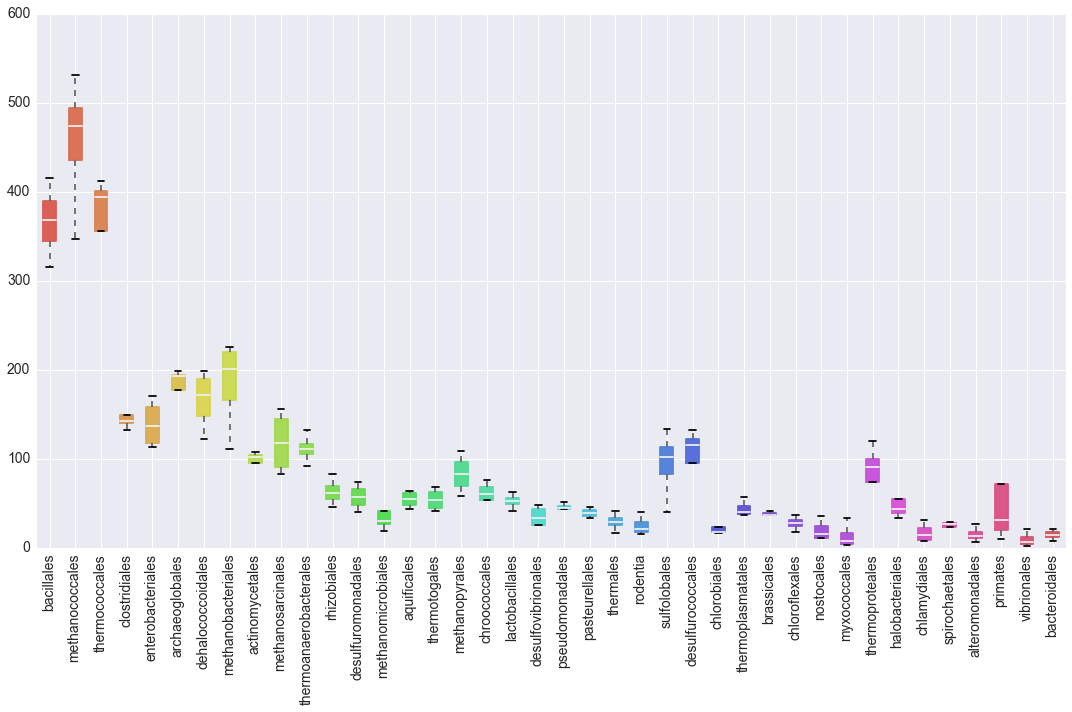

In [110]:
fig, ax = mgkit.plots.get_single_figure(figsize=(15, 10))
_ = mgkit.plots.boxplot.boxplot_dataframe(
    taxa_counts, 
    taxa_counts.index[:40], 
    ax, 
    fonts=dict(fontsize=14),
    data_colours={
        x: color
        for x, color in zip(taxa_counts.index[:40], seaborn.color_palette('hls', 40))
    }
)
fig.tight_layout()
fig.savefig('taxa_counts-boxplot_top40_taxa.pdf')

#### Distribution of Taxa by Depth

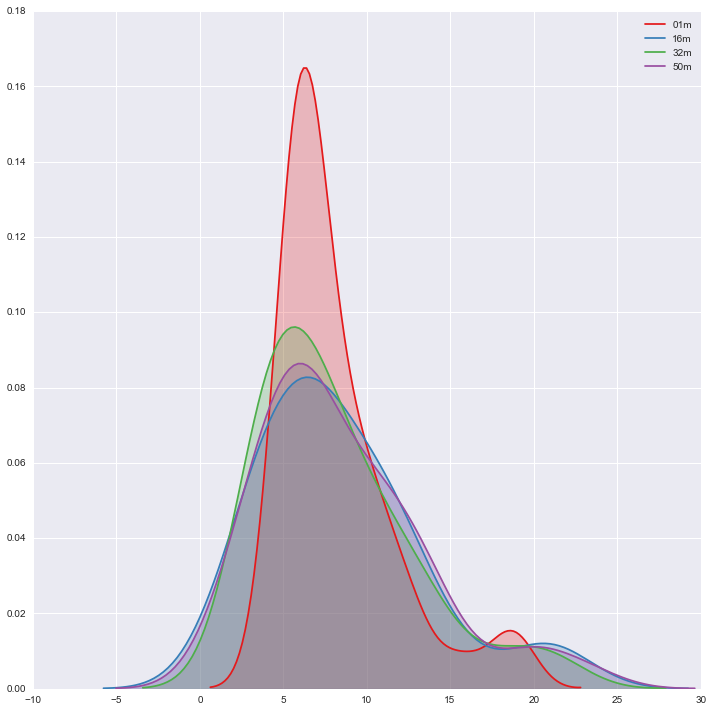

In [111]:
fig, ax = mgkit.plots.get_single_figure(figsize=(10, 10))
for column, color in zip(taxa_counts.columns, seaborn.color_palette('Set1', len(taxa_counts.columns))):
    seaborn.kdeplot(
        numpy.sqrt(taxa_counts[column].iloc[:40]),
        color=color,
        label=column,
        shade=True
    )
ax.legend()
fig.tight_layout()
fig.savefig('taxa_counts-distribution_top40_taxa.pdf')

#### Heatmap of the Table

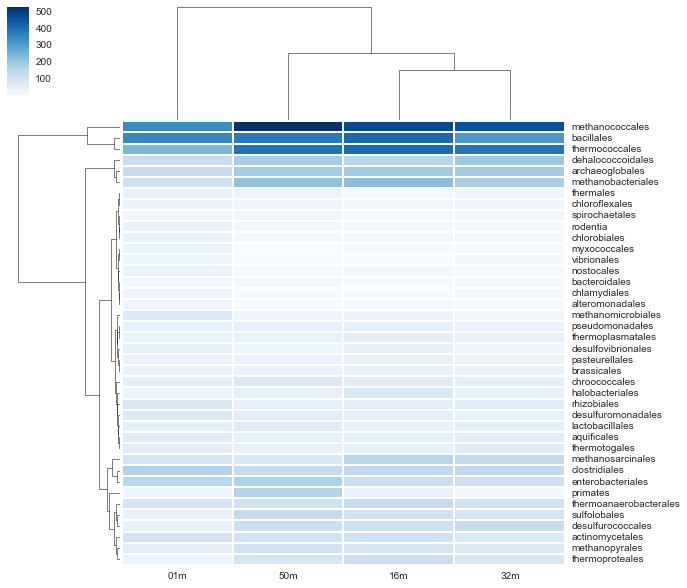

In [148]:
seaborn.clustermap(taxa_counts.iloc[:40], cbar=True, cmap='Blues')
fig = plt.gcf()
fig.savefig('taxa_counts-heatmap-top40.pdf')

### Functional Categories

#### Load Necessary Data

In [116]:
eg = eggnog.NOGInfo()

In [127]:
#Just a few to speed up the analysis
#Should have been downloaded by the full tutorial script
eg.load_members('COG.members.txt.gz')
eg.load_members('NOG.members.txt.gz')
eg.load_funccat('COG.funccat.txt.gz')
eg.load_funccat('NOG.funccat.txt.gz')

In [130]:
#Build mapping Uniprot IDs -> eggNOG functional categories
fc_map = {
    annotation.gene_id: eg.get_nogs_funccat(annotation.get_mapping('eggnog'))
    for annotation in annotations.itervalues()
}

#### Build FC Table

In [135]:
fc_counts = pandas.DataFrame({
    file_name_to_sample(file_name): mgkit.counts.load_sample_counts_to_genes(
        lambda x: (annotations[x].gene_id, annotations[x].taxon_id),
        mgkit.counts.load_htseq_counts(file_name),
        taxonomy,
        gene_map=fc_map
    )
    for file_name in counts
})

#### Scale the Table and Rename Rows/Columns

In [139]:
fc_counts = mgkit.counts.scale_deseq(fc_counts).rename(
    columns=sample_names,
    index=eggnog.EGGNOG_CAT
)

In [140]:
#Save table to disk
fc_counts.to_csv('fc_counts.csv')

#### Heatmap to Explore Functional Categories

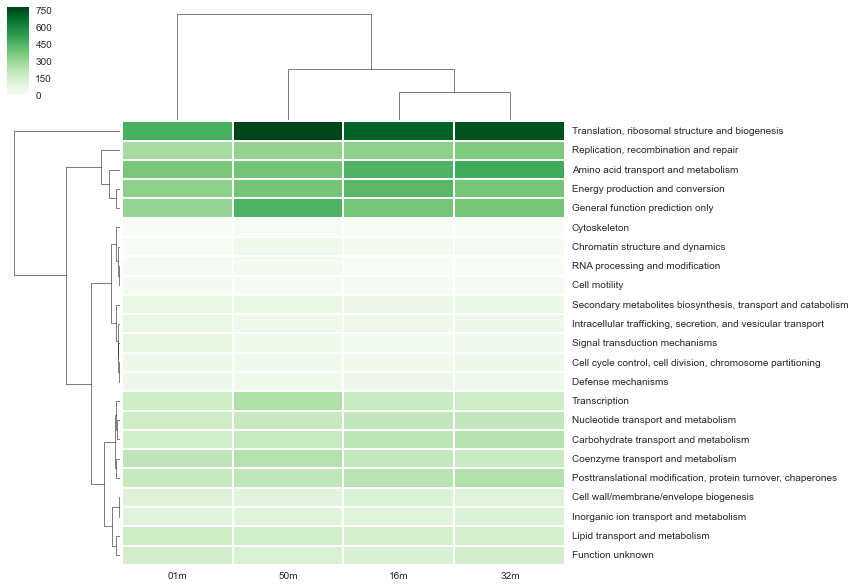

In [149]:
seaborn.clustermap(fc_counts, cbar=True, cmap='Greens')
fig = plt.gcf()
fig.savefig('fc_counts-heatmap.pdf')

## Explore Diversity

### Taxa

In [180]:
pnps = mgkit.snps.get_rank_dataframe(snp_data, taxonomy, min_num=3, rank='order', index_type='taxon')

In [181]:
pnps = pnps.rename(
    columns=sample_names,
    index=lambda x: taxonomy[x].s_name
)

In [182]:
pnps.describe()

,16m,32m,01m,50m
count,23.000000,20,26.000000,25.000000
mean,0.157490,0,0.269989,0.383241
std,0.358996,0,0.464452,0.492235
min,0.000000,0,0.000000,0.000000
25%,0.000000,0,0.000000,0.000000
50%,0.000000,0,0.000000,0.000000
75%,0.000000,0,0.587940,0.875000
max,1.117518,0,1.415323,1.402299


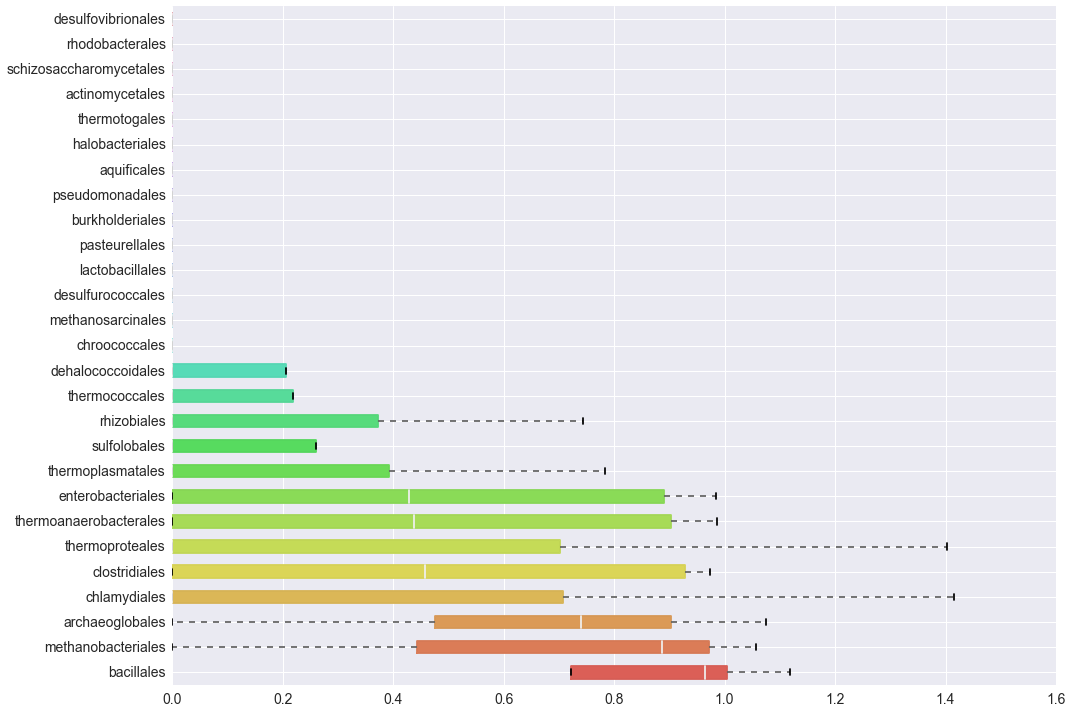

In [205]:
#sort the DataFrame to plot them by mean value
plot_order = pnps.mean(axis=1).sort(inplace=False, ascending=False).index

fig, ax = mgkit.plots.get_single_figure(figsize=(15, 10))
_ = mgkit.plots.boxplot.boxplot_dataframe(
    pnps, 
    plot_order, 
    ax, 
    fonts=dict(fontsize=14, rotation='horizontal'),
    data_colours={
        x: color
        for x, color in zip(plot_order, seaborn.color_palette('hls', len(pnps.index)))
    },
    box_vert=False
)
fig.tight_layout()
fig.savefig('pnps-taxa-boxplot.pdf')

### Functional Categories

In [193]:
fc_pnps = mgkit.snps.get_gene_map_dataframe(snp_data, taxonomy, min_num=3, gene_map=fc_map, index_type='gene')

In [194]:
fc_pnps = fc_pnps.rename(
    columns=sample_names,
    index=eggnog.EGGNOG_CAT
)

In [195]:
fc_pnps.describe()

,16m,32m,01m,50m
count,17.000000,14,18.000000,16.000000
mean,0.253276,0,0.610984,0.793588
std,0.419100,0,0.511969,0.634869
min,0.000000,0,0.000000,0.000000
25%,0.000000,0,0.000000,0.530885
50%,0.000000,0,0.875221,0.838567
75%,0.474000,0,1.027128,1.023866
max,0.993318,0,1.288820,2.570637


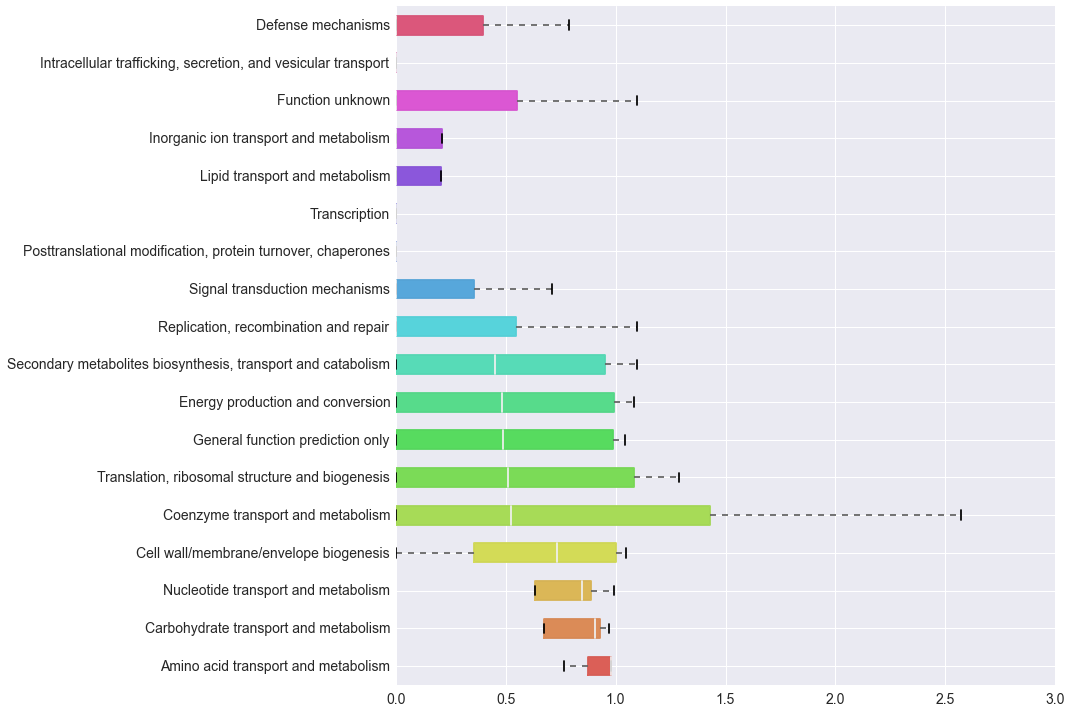

In [206]:
#sort the DataFrame to plot them by median value
plot_order = fc_pnps.median(axis=1).sort(inplace=False, ascending=False).index

fig, ax = mgkit.plots.get_single_figure(figsize=(15, 10))
_ = mgkit.plots.boxplot.boxplot_dataframe(
    fc_pnps, 
    plot_order, 
    ax, 
    fonts=dict(fontsize=14, rotation='horizontal'),
    data_colours={
        x: color
        for x, color in zip(plot_order, seaborn.color_palette('hls', len(fc_pnps.index)))
    },
    box_vert=False
)
fig.tight_layout()
fig.savefig('pnps-fc-boxplot.pdf')